This code uses sardine, anchovy landings data  and SST(Sea Surface Temperature) data and applies Lingam algorithm to infer causal relationship between these three variables.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
import sklearn
import math
import networkx as nx
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
from sklearn.ensemble import RandomForestRegressor
from numpy import trapz
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from copy import copy, deepcopy
%matplotlib inline
plt.style.use("ggplot")

plt.rcParams["figure.figsize"] = (16,3)


Sea surface temperature (SST) was measured at shore stations: Scripps Pier and Newport Pier (data available from: http://shorestation.ucsd.edu/active/index_active.html). Monthly means were averaged to form yearly time series, and the final time series consisted of 3-year running averages for the SST.


In [57]:
scripps = pd.read_csv("SIO.txt",delimiter=' ',encoding='utf-8')
scripps.head()

,YEAR,MONTH,DAY,TIME_PST,TIME_FLAG,SURF_TEMP_C,SURF_FLAG,BOT_TEMP_C,BOT_FLAG
0,1916.0,8.0,22.0,NaN,NaN,19.5,0.0,NaN,NaN
1,1916.0,8.0,23.0,NaN,NaN,19.9,0.0,NaN,NaN
2,1916.0,8.0,24.0,NaN,NaN,19.7,0.0,NaN,NaN
3,1916.0,8.0,25.0,NaN,NaN,19.7,0.0,NaN,NaN
4,1916.0,8.0,26.0,NaN,NaN,19.5,0.0,NaN,NaN


In [58]:
scripps_monthly=scripps[["YEAR","MONTH","SURF_TEMP_C"]].groupby(["YEAR","MONTH"]).mean().reset_index()
scripps_monthly.head()

,YEAR,MONTH,SURF_TEMP_C
0,1916.0,8.0,19.311111
1,1916.0,9.0,18.130769
2,1916.0,10.0,15.680000
3,1916.0,11.0,14.208000
4,1916.0,12.0,13.128000


Monthly means were averaged to form yearly time series.

In [61]:
scripps_yearly=scripps[["YEAR","SURF_TEMP_C"]].groupby(["YEAR"]).mean().reset_index()
scripps_yearly.head() 

,YEAR,SURF_TEMP_C
0,1916.0,15.641818
1,1917.0,16.742715
2,1918.0,17.385113
3,1919.0,16.810032
4,1920.0,16.576177


Final time series consisted of 3-year running averages for the SST.

In [63]:
scripps_yearly=scripps_yearly.rolling(window=3).mean()

In [64]:
scripps_yearly=scripps_yearly[(scripps_yearly["YEAR"]>=1928) & (scripps_yearly["YEAR"]<=2006)]


Text(0.5, 1.0, 'Scripps Pier Sea Surf temperature yearly data from 1928 to 2006')

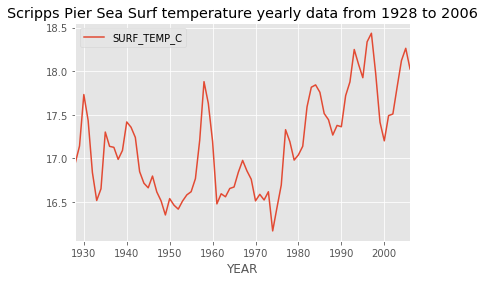

In [132]:
figsc=scripps_yearly.plot("YEAR","SURF_TEMP_C")
figsc.set_title('Scripps Pier Sea Surf temperature yearly data from 1928 to 2006')


In [76]:
newport = pd.read_csv("Newport.csv",delimiter=' ',encoding='utf-8')
newport.head()  

,YEAR,MONTH,DAY,TIME_PST,TIME_FLAG,SURF_TEMP_C,TEMP_FLAG
0,1924,11,1,NaN,NaN,NaN,NaN
1,1924,11,2,NaN,NaN,NaN,NaN
2,1924,11,3,NaN,NaN,NaN,NaN
3,1924,11,4,NaN,NaN,NaN,NaN
4,1924,11,5,NaN,NaN,NaN,NaN


In [77]:
newport_monthly=newport[["YEAR","MONTH","SURF_TEMP_C"]].groupby(["YEAR","MONTH"]).mean().reset_index()

Monthly means were averaged to form yearly time series

In [78]:
newport_yearly=newport[["YEAR","SURF_TEMP_C"]].groupby(["YEAR"]).mean().reset_index()
newport_yearly.head() 

,YEAR,SURF_TEMP_C
0,1924,13.744186
1,1925,16.149359
2,1926,17.297692
3,1927,15.835776
4,1928,17.210674


Final time series consisted of 3-year running averages for the SST.

In [79]:
newport_yearly=newport_yearly.rolling(window=3).mean()

In [80]:
newport_yearly=newport_yearly[(newport_yearly["YEAR"]>=1928) & (newport_yearly["YEAR"]<=2006)]


Text(0.5, 1.0, 'Newport Pier Sea Surf temperature yearly data from 1928 to 2006')

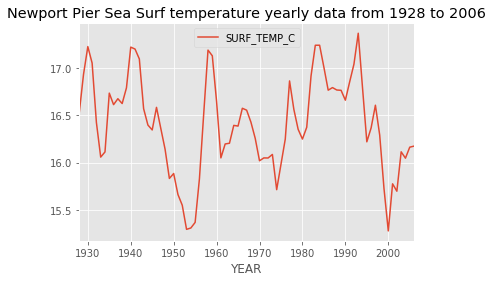

In [133]:
fign=newport_yearly.plot("YEAR","SURF_TEMP_C")
fign.set_title('Newport Pier Sea Surf temperature yearly data from 1928 to 2006')


California landings data for Pacific sardine (Sardinops sagax) and northern anchovy (Engraulis mordax) were taken from two sources: 1. (1928 – 2002) NOAA Southwest Fisheries Science Center (https://coastwatch.pfeg.noaa.gov/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=erdCAMarCat) 2. (2003 – 2006) California Department of Fish and Game (https://oceanview.pfeg.noaa.gov/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=CA_mkt_catch)

# Sardine

In [82]:
sardine1 = pd.read_csv("sardine.txt",delimiter=' ',encoding='utf-8').reset_index()[["time","landings"]]
sardine1.columns=["YEAR","landings"]
sardine1.head()

,YEAR,landings
0,1928,40874524
1,1928,95819881
2,1928,42943442
3,1928,4195019
4,1928,3380067


In [83]:
sardine1_yearly=sardine1.groupby("YEAR").sum().reset_index()
sardine1_yearly.head()

,YEAR,landings
0,1928,420269665
1,1929,651771904
2,1930,494450747
3,1931,301307801
4,1932,312171650


In [85]:
sardine2= pd.read_csv("sardine2.txt",skiprows=2,delimiter="\t",names=["YEAR","fish","landings","port"])
sardine2.loc[:,"YEAR"]=sardine2.loc[:,"YEAR"].apply(lambda x:int(x[0:4]))
sardine2.head()

,YEAR,fish,landings,port
0,2003,"Sardine, Pacific",17432494,Monterey
1,2003,"Sardine, Pacific",5221404,Santa Barbara
2,2003,"Sardine, Pacific",61930,San Diego
3,2003,"Sardine, Pacific",250,San Francisco
4,2004,"Sardine, Pacific",34047402,Monterey


In [86]:
sardine2=sardine2[(sardine2["YEAR"]>=2003) & (sardine2["YEAR"]<=2006)]


In [87]:
sardine2_yearly=sardine2[["YEAR","landings"]].groupby(["YEAR"]).sum().reset_index()

In [89]:
sardine_yearly=pd.concat([sardine1_yearly,sardine2_yearly],axis=0)

Text(0.5, 1.0, 'Sardine landings yearly data from 1928 to 2006')

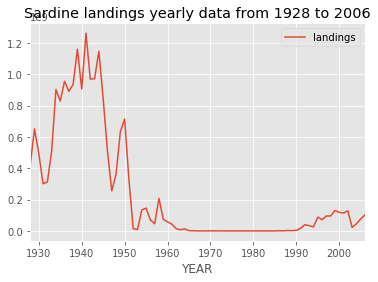

In [134]:
figs=sardine_yearly.plot("YEAR","landings")
figs.set_title('Sardine landings yearly data from 1928 to 2006')


In [91]:
anchovy1 = pd.read_csv("Anchovy.txt",delimiter=' ',encoding='utf-8',).reset_index()[["time","landings"]]
anchovy1.columns=["YEAR","landings"]

anchovy1.head()

,YEAR,landings
0,1928,1190
1,1928,155
2,1928,0
3,1928,23137
4,1928,187335


In [92]:
anchovy1_yearly=anchovy1.groupby("YEAR").sum().reset_index()
anchovy1_yearly.head()

,YEAR,landings
0,1928,357470
1,1929,382445
2,1930,319561
3,1931,307494
4,1932,299217


In [94]:
anchovy2= pd.read_csv("Anchovy2.txt",skiprows=2,delimiter="\t",names=["YEAR","fish","landings","port"])
anchovy2.loc[:,"YEAR"]=anchovy2.loc[:,"YEAR"].apply(lambda x:int(x[0:4]))
anchovy2.head()

,YEAR,fish,landings,port
0,2003,"Anchovy, Northern",1555834.0,Monterey
1,2003,"Anchovy, Northern",1378832.0,Santa Barbara
2,2003,"Anchovy, Northern",29972.0,San Diego
3,2003,"Anchovy, Northern",0.0,San Francisco
4,2004,"Anchovy, Northern",8577584.0,Monterey


In [95]:
anchovy2=anchovy2[(anchovy2["YEAR"]>=2003) & (anchovy2["YEAR"]<=2006)]


In [96]:
anchovy2_yearly=anchovy2[["YEAR","landings"]].groupby(["YEAR"]).sum().reset_index()

In [97]:
anchovy_yearly=pd.concat([anchovy1_yearly,anchovy2_yearly],axis=0)

Text(0.5, 1.0, 'Anchovy landings yearly data from 1928 to 2006')

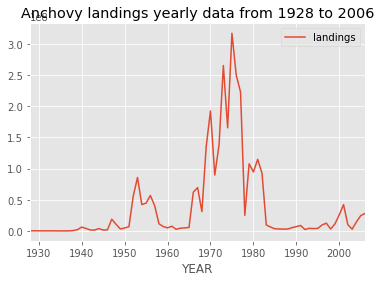

In [135]:
figa=anchovy_yearly.plot("YEAR","landings")
figa.set_title('Anchovy landings yearly data from 1928 to 2006')


# Causality Analysis

Tested for linkages between sardine and anchovy, sardine versus Scripps Pier SST, and anchovy versus Newport Pier SST.

In [107]:
A=pd.merge(sardine_yearly,anchovy_yearly, left_on='YEAR', right_on='YEAR') 

In [108]:
B=pd.merge(A,newport_yearly, left_on='YEAR', right_on='YEAR') 

In [109]:
ALL=pd.merge(B,scripps_yearly, left_on='YEAR', right_on='YEAR') 

In [110]:
ALL.columns=["year","sardine","anchovy","newport","scripps"]

In [111]:
ALL.head()

,year,sardine,anchovy,newport,scripps
0,1928,420269665,357470.0,16.527637,16.944251
1,1929,651771904,382445.0,16.935989,17.141394
2,1930,494450747,319561.0,17.229600,17.731116
3,1931,301307801,307494.0,17.055242,17.436047
4,1932,312171650,299217.0,16.425193,16.836986


In [112]:
ALL=ALL.drop(["year"], axis=1)

lingam is abbreviation of "Linear Non-Gaussian Acyclic Model" is a method for Causal Discovery.The key to the solution to the linear discovery problem is to realize that the observed variables are
linear functions of the disturbance variables, and the disturbance variables are mutually independent
and non-Gaussian.

In [113]:
%run lingam.py

<Figure size 432x288 with 0 Axes>

In [136]:
#use kurtosis base ICA
lingam = LiNGAM()
lingam.fit(ALL)

anchovy ---|-2.272|---> sardine
newport ---|235665784.114|---> sardine
scripps ---|-299751409.606|---> sardine
newport ---|-16764047.118|---> anchovy
scripps ---|-32740421.159|---> anchovy
scripps ---|0.469|---> newport


array([[ 0.00000000e+00, -2.27156571e+00,  2.35665784e+08,
        -2.99751410e+08],
       [ 0.00000000e+00,  0.00000000e+00, -1.67640471e+07,
        -3.27404212e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.69097300e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

High values in causality matrix indicates more probable causality.Direction of arrow indicates direction of causality.The causalities discovered was simillar to causalities that the paper "Detecting Causality Complex Ecosystems data" written by Sugihara et al. which says: "signal between sardine and anchovy landings, indicating that sardines and anchovies do not interact. In addition, as expected, there is no detectable signature from either sardine or anchovy in the temperature manifold; obviously, neither sardines nor anchovies affect SST. However, there is clear causality between sardines and SST as well as between anchovies and SST,meaning that temperature information is encoded in both fishery time series. The recoverable temperature signature reveals a weak coupling of temperature to sardines and anchovies. Thus, although sardines and anchovies are not actually interacting, they are weakly forced by a common environmental driver, for which temperature is at least a viable proxy.

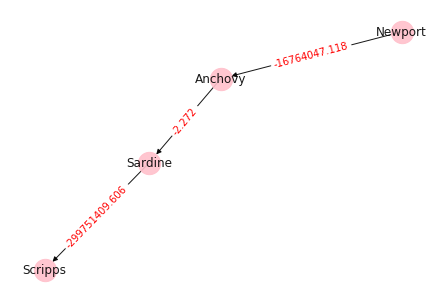

In [321]:
import networkx as nx
edges=[['Anchovy','Sardine'],['Sardine','Scripps'],['Newport','Anchovy']]
G=nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()    
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=500,node_color='pink',alpha=0.9,\
labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels={( 'Newport','Anchovy'):'-16764047.118',\
( 'Anchovy','Sardine'):'-2.272',('Sardine','Scripps'):'-299751409.606'},font_color='red')
plt.axis('off')
plt.show()